In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

In [ ]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [ ]:
df = pd.read_csv('data/train_masks.csv')
df.shape

(5088, 2)

In [ ]:
train_df = df[:4000]
val_df = df[4000:].reset_index(drop=True)

In [ ]:
df[:5]

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [ ]:
img_name, mask_rle = train_df.iloc[1201]

img = cv2.imread('data/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

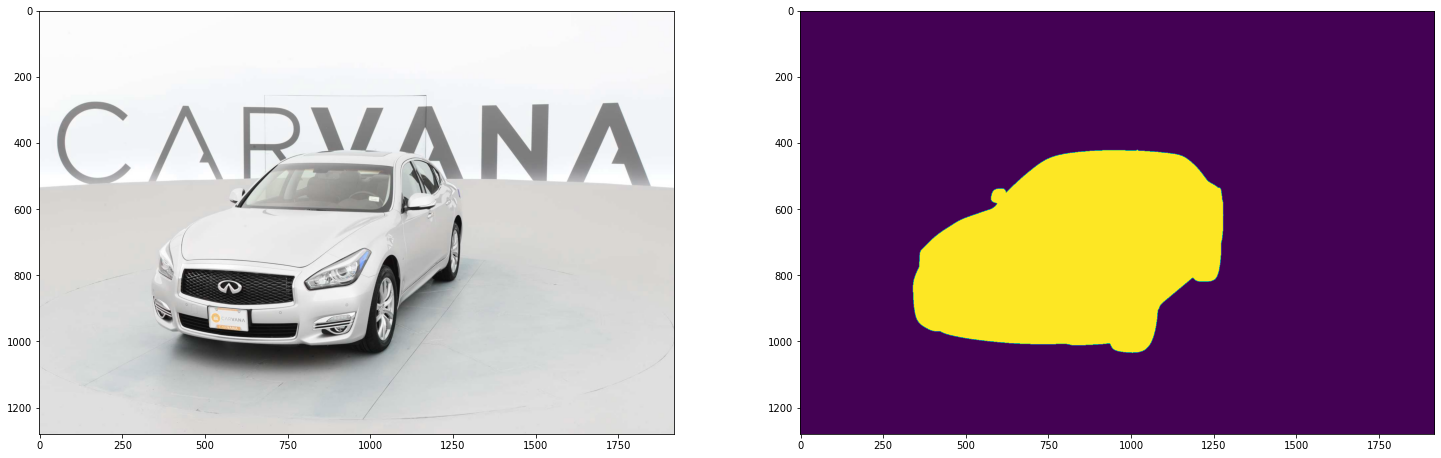

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)
axes[1].imshow(mask[..., 0])

plt.show()

In [ ]:
class SegDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transforms_x = nn.Sequential(
            T.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name, mask_rle = self.dataset.iloc[idx].values
        img = cv2.imread('data/train/{}'.format(img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = T.functional.to_tensor(img)
        img = self.transforms_x(img)
        
        mask = rle_decode(mask_rle)
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, 0)
        mask = torch.from_numpy(mask)

        return img, mask

In [ ]:
for x, y in SegDataset(train_df):
    break
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [ ]:
(y>0.5).sum() #всего ~64k

tensor(11610)

In [ ]:
np.unique(y.detach().cpu().numpy()) # binary masj

array([0, 1], dtype=uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


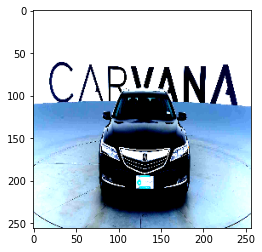

In [ ]:
plt.imshow(x.numpy().astype(float).transpose(1, 2, 0))

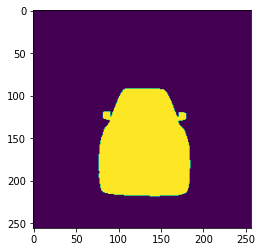

In [ ]:
plt.imshow(y.numpy().transpose(1, 2, 0).reshape(256, 256))

In [ ]:
train_dataloader = DataLoader(SegDataset(train_df), batch_size=1)

In [ ]:
for x, y in train_dataloader:
    break
x.shape, y.shape # нулевое измерение -- размер батча

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256, 256]))

# SegNet

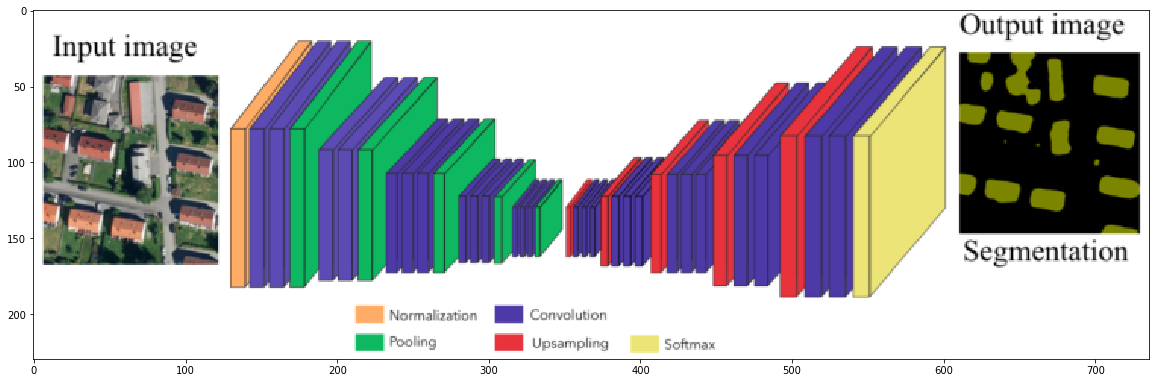

In [ ]:
seg_png = cv2.imread('segnet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [ ]:
new_model_bn = nn.Sequential(
    nn.Conv2d(3, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(32, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(64, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(128, 256, (3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, (3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(256, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(128, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(64, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(32, 1, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(1, 1, (3, 3), padding=1)
    )

In [ ]:
new_model_bn(x.float()).size()

torch.Size([1, 1, 256, 256])

In [ ]:
train_dataloader = DataLoader(SegDataset(train_df), batch_size=32, num_workers=2, drop_last=True)
test_dataloader = DataLoader(SegDataset(val_df), batch_size=32, num_workers=2, drop_last=True)

In [ ]:
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

if torch.cuda.is_available():
    new_model_bn.to('cuda')

In [ ]:
scaler = torch.cuda.amp.GradScaler()
for epoch in range(5):
    new_model_bn.train()
    for (batch_idx, (data, y)) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            data = data.to('cuda').float()
            y = y.to('cuda').float()

        optimizer.zero_grad()

        # Casts operations to mixed precision
        with torch.cuda.amp.autocast():
            ypred = new_model_bn(data)
            loss = criterion(ypred, y)

        # Scales the loss, and calls backward()
        # to create scaled gradients
#             loss.backward()
        scaler.scale(loss).backward()

        # Unscales gradients and calls
        # or skips optimizer.step()
#             optimizer.step()
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()

    print(f"EPOCH {epoch}, Train Loss: {loss.item()}")
    
    if test_dataloader is not None:
        new_model_bn.eval()
        with torch.no_grad():
            for (batch_idx, (data, y)) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    data = data.to('cuda:0').float()
                    y = y.to('cuda:0').float()
                
                with torch.cuda.amp.autocast():
                    ypred = new_model_bn(data)
                    loss = criterion(ypred, y)
    
    print(f"EPOCH {epoch}, Test Loss: {loss.item()}")

EPOCH 0, Train Loss: 0.702944815158844
EPOCH 0, Test Loss: 0.7000088691711426
EPOCH 1, Train Loss: 0.702944815158844
EPOCH 1, Test Loss: 0.7000105977058411
EPOCH 2, Train Loss: 0.702944815158844
EPOCH 2, Test Loss: 0.7000105977058411
EPOCH 3, Train Loss: 0.702944815158844
EPOCH 3, Test Loss: 0.7000105977058411
EPOCH 4, Train Loss: 0.702944815158844
EPOCH 4, Test Loss: 0.7000105977058411


In [ ]:
pred = new_model_bn(data.float().to('cuda'))

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
np.unique(pred)

array([-0.03688041, -0.02930737, -0.02883673, ...,  1.4960974 ,
        1.496491  ,  1.5087808 ], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


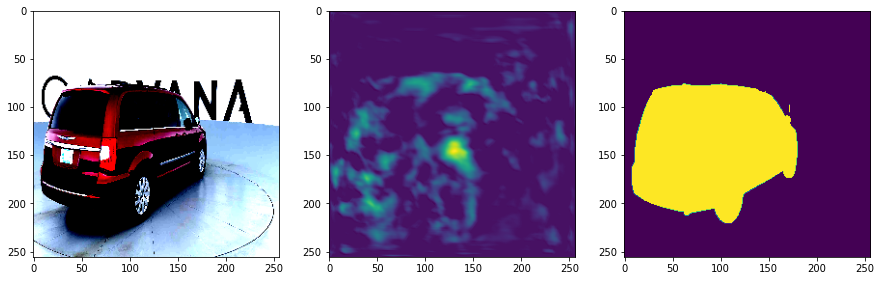

In [ ]:
im_id = 10
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(data[im_id].detach().cpu().numpy().astype(float).transpose((1, 2, 0)))
axes[1].imshow((pred[im_id]).transpose((1, 2, 0)).reshape(256, 256))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose((1, 2, 0)).reshape(256, 256))

plt.show()

# Vanilla Unet

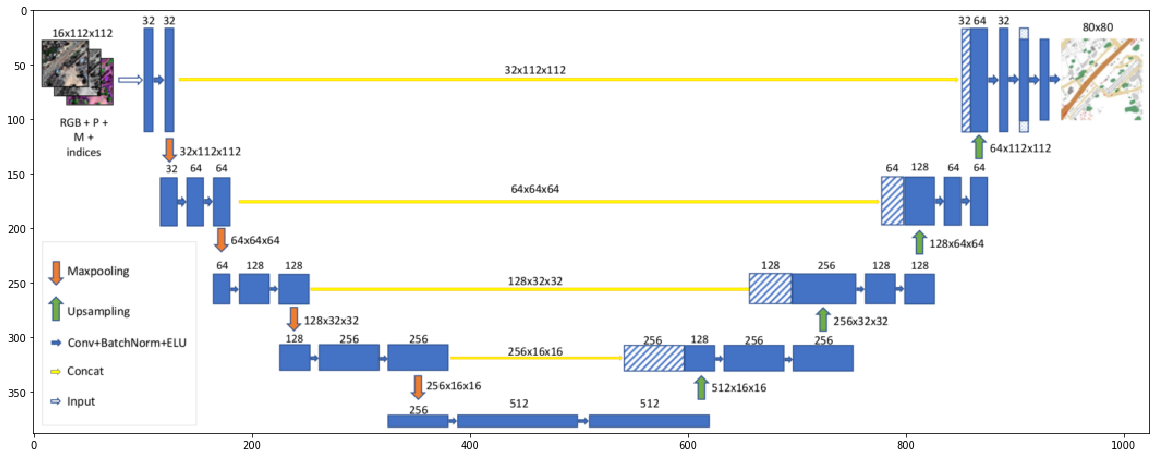

In [ ]:
seg_png = cv2.imread('unet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(height=256, width=256, always_apply=True),

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height=256, width=256, always_apply=True),
        albu.PadIfNeeded(256, 256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if image.shape[2]>1:
          plt.imshow(image.reshape(256, 256, -1))
        else:
          plt.imshow(image.reshape(256, 256))
    plt.show()

In [ ]:
class SegDataset(Dataset):
    def __init__(
            self, 
            dataset, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.dataset = dataset
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # read data
        img_name, mask_rle = self.dataset.iloc[i].values
        image = cv2.imread('data/train/{}'.format(img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = rle_decode(mask_rle)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.dataset)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

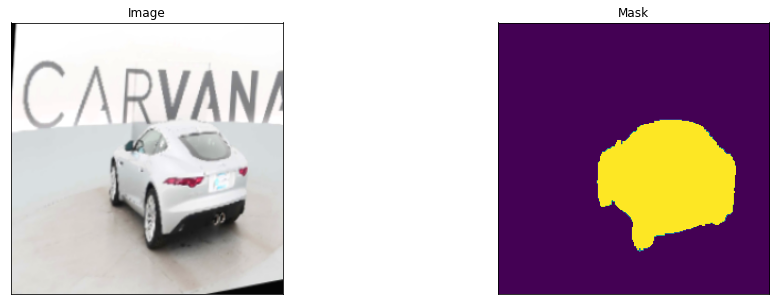

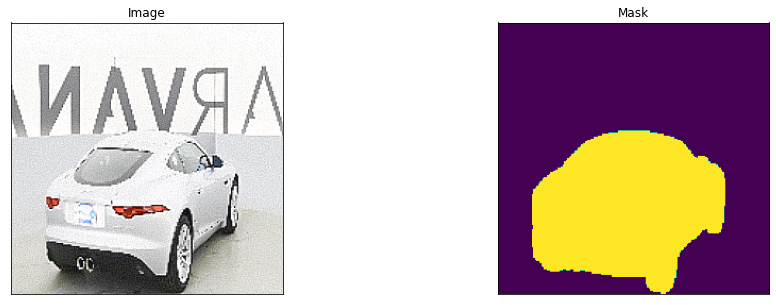

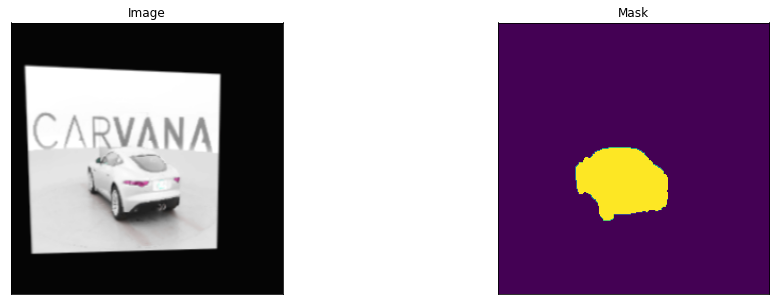

In [ ]:
augmented_dataset = SegDataset(
    train_df, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[55]
    visualize(image=image, mask=mask)

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [ ]:
train_dataset = SegDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)
test_dataset = SegDataset(
    val_df, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),]

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001),])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(test_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 272/272 [01:02<00:00,  4.32it/s, dice_loss - 0.05725, iou_score - 0.9655]
Model saved!

Epoch: 1
valid: 100%|██████████| 272/272 [01:03<00:00,  4.32it/s, dice_loss - 0.02475, iou_score - 0.978]
Model saved!

Epoch: 2
train:  38%|███▊      | 188/500 [03:22<05:36,  1.08s/it, dice_loss - 0.02518, iou_score - 0.9712]


KeyboardInterrupt: ignored

In [ ]:
best_model = torch.load('./best_model.pth')

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = SegDataset(val_df)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

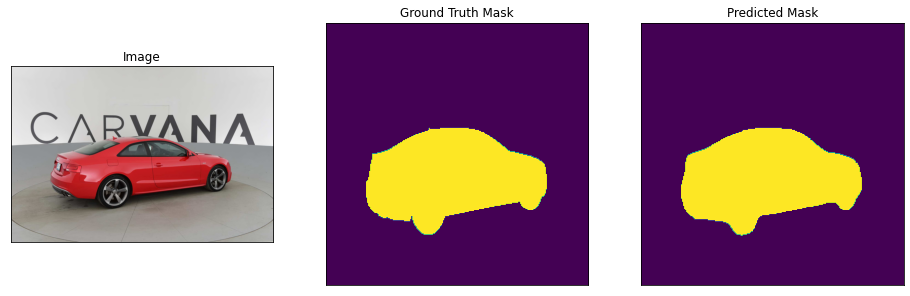

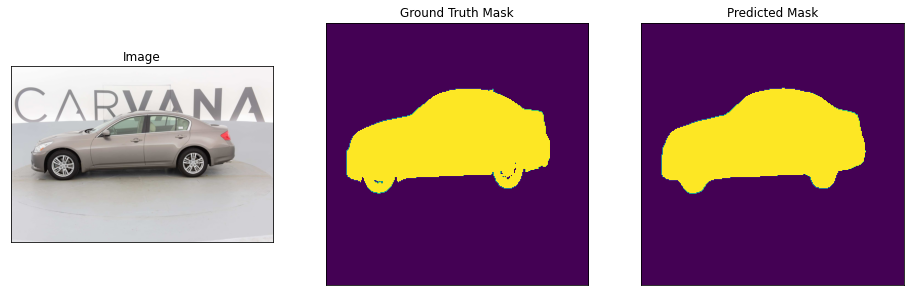

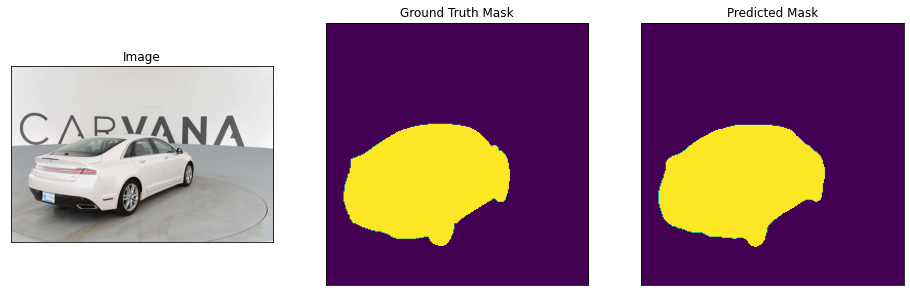

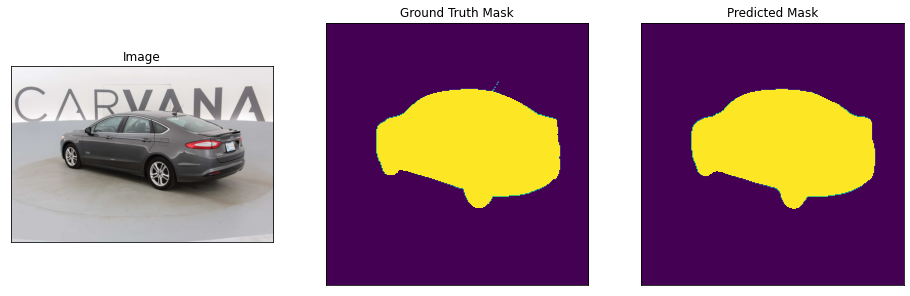

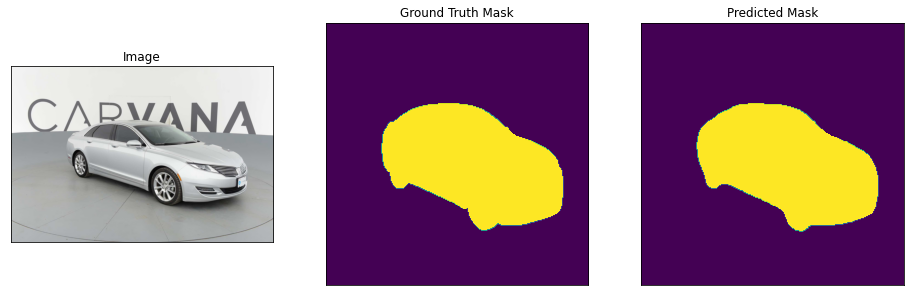

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )